In [51]:
import pandas as pd
import numpy as np
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from collections import Counter
from nltk.corpus import stopwords
import os
import re
import string
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras import backend as K

In [53]:
top_words = 5000
epoch_num = 5
batch_size = 64


In [54]:
#df_train = pd.read_csv('data/train_kaggle.csv', sep=',', encoding='utf-8')
df_train = pd.read_pickle('data/data_train.pkl')
df_test = pd.read_pickle('data/data_test.pkl')

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6796 entries, 5014 to 9265
Data columns (total 7 columns):
content       6796 non-null object
id            6796 non-null object
label         6796 non-null int64
media-type    6796 non-null object
published     6796 non-null object
source        6796 non-null object
title         6796 non-null object
dtypes: int64(1), object(6)
memory usage: 424.8+ KB


In [56]:
def textClean(text):
    """
    Get rid of the non-letter and non-number characters
    """
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)

def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

In [57]:
df_train.head(5)

,content,id,label,media-type,published,source,title
5014,In 1939 the German military commanders had pla...,a53a9da1-2643-4b88-aa05-979f98914908,1,News,2015-09-09T15:31:01Z,Global Research,Why Did Nazi Germany Fail to Create a Ukrainia...
347,HMS Industrial Networks Provides Robust Multi-...,eea36487-9c64-4b79-808b-2576d60d06f7,0,News,2015-09-16T11:14:10Z,Reuters,Microsemi Collaborates with HMS Industrial Net...
8990,* Gold in tight range until Fed meet next week...,5c30364c-9689-4135-a6c7-9cda2b27aee1,0,News,2015-09-09T14:20:43Z,Reuters,"PRECIOUS-Gold falls 1 pct as stocks rally, dol..."
4304,"PR Newswire \n \nGREENWICH, Conn., Sept. 9, 20...",3ae57dbc-86ac-488a-be5e-baac0aab888d,0,News,2015-09-09T12:25:44Z,Reuters,Littlejohn & Co. Completes Sale of Henniges Au...
9119,VDX and Gridstore Deliver Hyper-Converged Infr...,94a8027c-2dc2-47bd-915b-ea4ab8241717,0,News,2015-09-02T12:19:49Z,Reuters,Leading Consultancy VDX Inc. Joins Gridstore A...


In [58]:
missing_rows = []
df_train = df_train.reset_index()
for i in range(len(df_train)):
    if df_train.loc[i, 'content'] != df_train.loc[i, 'content']:
        missing_rows.append(i)

In [59]:
df_train = df_train.drop(missing_rows).reset_index().drop(['index','id'],axis=1)


In [60]:
df_train.head(7)

,level_0,content,label,media-type,published,source,title
0,0,In 1939 the German military commanders had pla...,1,News,2015-09-09T15:31:01Z,Global Research,Why Did Nazi Germany Fail to Create a Ukrainia...
1,1,HMS Industrial Networks Provides Robust Multi-...,0,News,2015-09-16T11:14:10Z,Reuters,Microsemi Collaborates with HMS Industrial Net...
2,2,* Gold in tight range until Fed meet next week...,0,News,2015-09-09T14:20:43Z,Reuters,"PRECIOUS-Gold falls 1 pct as stocks rally, dol..."
3,3,"PR Newswire \n \nGREENWICH, Conn., Sept. 9, 20...",0,News,2015-09-09T12:25:44Z,Reuters,Littlejohn & Co. Completes Sale of Henniges Au...
4,4,VDX and Gridstore Deliver Hyper-Converged Infr...,0,News,2015-09-02T12:19:49Z,Reuters,Leading Consultancy VDX Inc. Joins Gridstore A...
5,5,Form 8.3 - SABMILLER PLC \n \n \n \nFORM 8.3 \...,0,News,2015-09-21T13:43:08Z,Reuters,REG-BARCLAYS PLC Form 8.3 - SABMILLER PLC
6,6,"CEA Proves Continued Commitment to Employees, ...",0,News,2015-09-24T17:03:24Z,Reuters,"CEA Proves Continued Commitment to Employees, ..."


In [61]:
for i in range(len(df_train['content'])):
        df_train.loc[i, 'content'] = cleanup(df_train.loc[i,'content'])

In [62]:
#change above X if we r using tokenize and other nlp process
#Dropping the Nan values and info
#df_train.dropna(inplace=True)
X = df_train['content']
y = df_train['label']

# do the similar think on headline (author ?? or source)
# name these to test , validation
X_train,  X_test,  y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)


In [63]:
cnt = Counter()
X_train_modified = []
for x in X_train:
    X_train_modified.append(x.split())
    for word in X_train_modified[-1]:
        cnt[word] += 1  

# Storing most common words
most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1


In [64]:
# Encode the sentences
for news in X_train_modified:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]


In [65]:
y_train = list(y_train)
y_test = list(y_test)

# Delete the short news
i = 0
while i < len(X_train_modified):
    if len(X_train_modified[i]) > 10:
        i += 1
    else:
        del X_train_modified[i]
        del y_train[i]


In [66]:
# Generating test data
x_test = []
for x in X_test:
    x_test.append(x.split())

# Encode the sentences
for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]


In [76]:
# Truncate and pad input sequences
max_article_length = 500
X_train = sequence.pad_sequences(X_train_modified, maxlen=max_article_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_article_length)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)


In [77]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vecor_length, input_length=max_article_length))

In [78]:
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

# Draw the confusion matrix
y_pred = model.predict_classes(X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           160064    
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 168,417
Trainable params: 168,417
Non-trainable params: 0
_________________________________________________________________
None
Train on 5398 samples, validate on 1360 samples
Epoch 1/5
5398/5398 [==============================] - 37s 7ms/step - loss: 0.4854 - acc: 0.7545 - val_loss: 0.3894 - val_acc: 0.8390
Epoch 2/5
5398/5398 [==============================] - 38s 7ms/step - loss: 0.2040 - acc: 0.9287 - val_loss: 0.2317 - val_acc: 0.9066
Epoch 3/5
5398/5398 [==============================] - 37s 7ms/step - loss: 0.1

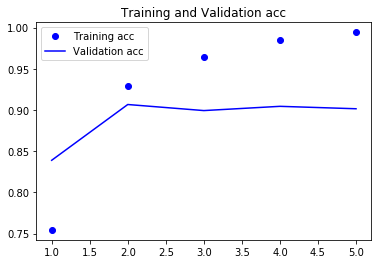

In [86]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.legend()
plt.figure()

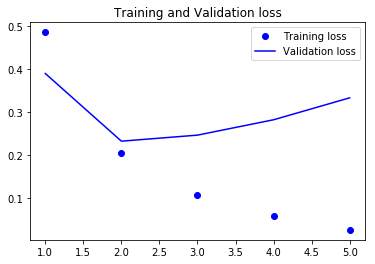

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Using Custom F1 metric

In [69]:
def f1(y_true, y_pred):
    #Only computes a batch-wise average of precision.
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [73]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vecor_length, input_length=max_article_length))

In [74]:
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

# Draw the confusion matrix
y_pred = model.predict_classes(X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           160064    
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 168,417
Trainable params: 168,417
Non-trainable params: 0
_________________________________________________________________
None
Train on 5398 samples, validate on 1360 samples
Epoch 1/5
5398/5398 [==============================] - 38s 7ms/step - loss: 0.4846 - f1: 0.3757 - val_loss: 0.3090 - val_f1: 0.8011
Epoch 2/5
5398/5398 [==============================] - 41s 8ms/step - loss: 0.2009 - f1: 0.8930 - val_loss: 0.2326 - val_f1: 0.8515
Epoch 3/5
5398/5398 [==============================] - 41s 8ms/step - loss: 0.1026 